In [1]:
import time
import os
import cv2

from lib.file.TIF import *
from lib.analysis.ROI_identification import *
from lib.file.ROI_writer import ROIFileWriter
from lib.file.ROI_reader import ROIFileReader
from lib.file.TSV import RegionExporter
from lib.analysis.align import ImageAlign
from lib.file.DAT import TracesDAT
from lib.trace import Tracer
from lib.utilities import *
from lib.analysis.laminar_dist import *

G:/.shortcut-targets-by-id/1agT5mnPWaZdQIB8nNNVWaVbqpbYNGxcB\2020-12-28\08-01-04_aka_part2_05-01-04_L4_interlaminar ['Old', 'Diagram'] ['08-01-04_snr.txt', 'electrode.dat', 'corners_barrel.dat', 'rois_01_to_17.dat', 'LaminarVisual08-01-04.png', 'desktop.ini']
slice 8 , rec 4
edge_pts [[79, 55], [79, 0]] axis_pts [[28, 53], [28, 0]]
laminar axis unit vectors: [0.9992319507315425, 0.039185566695354605] [1.0, 0.0]
Created roi: [[29, 53], [29, 52], [29, 51], [29, 50], [29, 49], [29, 48], [29, 47], [29, 46], [29, 45], [29, 44], [29, 43], [29, 42], [29, 41], [29, 40], [29, 39], [29, 38], [29, 37], [29, 36], [29, 35], [29, 34], [29, 33], [29, 32], [29, 31], [29, 30], [29, 29], [29, 28], [29, 27], [29, 26], [29, 25], [29, 24], [29, 23], [29, 22], [29, 21], [29, 20], [29, 19], [29, 18], [29, 17], [29, 16], [29, 15], [29, 14], [29, 13], [29, 12], [29, 11], [29, 10], [29, 9], [29, 8], [29, 7], [29, 6], [29, 5], [29, 4], [29, 3], [29, 2], [29, 1], [29, 0]]
Created roi: [[32, 53], [32, 52], [32, 51

Created roi: [[74, 55], [74, 54], [74, 53], [74, 52], [74, 51], [74, 50], [74, 49], [74, 48], [74, 47], [74, 46], [74, 45], [74, 44], [74, 43], [74, 42], [74, 41], [74, 40], [74, 39], [74, 38], [74, 37], [74, 36], [74, 35], [74, 34], [74, 33], [74, 32], [74, 31], [74, 30], [74, 29], [74, 28], [74, 27], [74, 26], [74, 25], [74, 24], [74, 23], [74, 22], [74, 21], [74, 20], [74, 19], [74, 18], [74, 17], [74, 16], [74, 15], [74, 14], [74, 13], [74, 12], [74, 11], [74, 10], [74, 9], [74, 8], [74, 7], [74, 6], [74, 5], [74, 4], [74, 3], [74, 2], [74, 1], [74, 0]]
Created roi: [[77, 55], [77, 54], [77, 53], [77, 52], [77, 51], [77, 50], [77, 49], [77, 48], [77, 47], [77, 46], [77, 45], [77, 44], [77, 43], [77, 42], [77, 41], [77, 40], [77, 39], [77, 38], [77, 37], [77, 36], [77, 35], [77, 34], [77, 33], [77, 32], [77, 31], [77, 30], [77, 29], [77, 28], [77, 27], [77, 26], [77, 25], [77, 24], [77, 23], [77, 22], [77, 21], [77, 20], [77, 19], [77, 18], [77, 17], [77, 16], [77, 15], [77, 14], [7

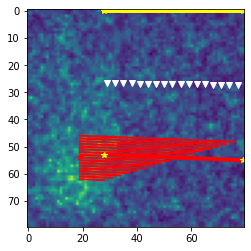

G:/.shortcut-targets-by-id/1agT5mnPWaZdQIB8nNNVWaVbqpbYNGxcB\2020-12-28\10-01-01_aka_part2_07-01-01_L4_interlaminar ['Old', 'Diagram'] ['10-01-01_snr.txt', 'electrode.dat', 'corners_barrel.dat', 'rois_01_to_14.dat', 'LaminarVisual10-01-01.png', 'desktop.ini']
slice 10 , rec 1
edge_pts [[79, 33], [79, 66]] axis_pts [[37, 63], [34, 33]]
laminar axis unit vectors: [1.0, 0.0] [0.997458699830735, 0.07124704998790965]
Created roi: [[35, 33], [35, 34], [35, 35], [35, 36], [35, 37], [35, 38], [36, 39], [36, 40], [36, 41], [36, 42], [36, 43], [36, 44], [36, 45], [36, 46], [36, 47], [36, 48], [37, 49], [37, 50], [37, 51], [37, 52], [37, 53], [37, 54], [37, 55], [37, 56], [37, 57], [37, 58], [38, 59], [38, 60], [38, 61], [38, 62], [38, 63], [38, 64], [38, 65], [38, 66], [38, 67], [38, 68], [39, 69], [39, 70], [39, 71], [39, 72], [39, 73], [39, 74], [39, 75], [39, 76], [39, 77], [39, 78], [40, 79], [41, 79], [42, 79], [43, 79], [44, 79], [45, 79], [46, 79], [47, 79], [48, 79], [49, 79], [50, 79], 

Created roi: [[71, 33], [71, 34], [71, 35], [71, 36], [71, 37], [71, 38], [72, 39], [72, 40], [72, 41], [72, 42], [72, 43], [72, 44], [72, 45], [72, 46], [72, 47], [72, 48], [73, 49], [73, 50], [73, 51], [73, 52], [73, 53], [73, 54], [73, 55], [73, 56], [73, 57], [73, 58], [74, 59], [74, 60], [74, 61], [74, 62], [74, 63], [74, 64], [74, 65], [74, 66], [74, 67], [74, 68], [75, 69], [75, 70], [75, 71], [75, 72], [75, 73], [75, 74], [75, 75], [75, 76], [75, 77], [75, 78], [76, 79], [77, 79], [78, 79], [79, 79]]
Created roi: [[74, 33], [74, 34], [74, 35], [74, 36], [74, 37], [74, 38], [75, 39], [75, 40], [75, 41], [75, 42], [75, 43], [75, 44], [75, 45], [75, 46], [75, 47], [75, 48], [76, 49], [76, 50], [76, 51], [76, 52], [76, 53], [76, 54], [76, 55], [76, 56], [76, 57], [76, 58], [77, 59], [77, 60], [77, 61], [77, 62], [77, 63], [77, 64], [77, 65], [77, 66], [77, 67], [77, 68], [78, 69], [78, 70], [78, 71], [78, 72], [78, 73], [78, 74], [78, 75], [78, 76], [78, 77], [78, 78], [79, 79]]
RO

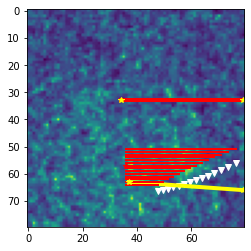

G:/.shortcut-targets-by-id/1agT5mnPWaZdQIB8nNNVWaVbqpbYNGxcB\2020-12-28\06-01-01_aka_part2_03-01-01_L4_interlaminar ['Old', 'Diagram'] ['06-01-01_snr.txt', 'electrode.dat', 'corners_barrel.dat', 'rois_01_to_14.dat', 'LaminarVisual06-01-01.png', 'rois_01_to_15.dat', 'desktop.ini']
slice 6 , rec 1
edge_pts [[79, 40], [79, 26]] axis_pts [[37, 45], [32, 56]]
laminar axis unit vectors: [0.946649906050144, -0.3222637978043043] [0.9111079228383558, -0.4121678698554467]
Created roi: [[33, 56], [33, 55], [34, 54], [34, 53], [35, 52], [35, 51], [35, 50], [36, 49], [36, 48], [37, 47], [37, 46], [38, 45], [38, 44], [39, 43], [39, 42], [40, 41], [40, 40], [40, 39], [41, 38], [41, 37], [42, 37], [42, 36], [42, 35], [43, 34], [43, 33], [44, 32], [44, 31], [45, 30], [45, 29], [45, 28], [46, 27], [47, 26], [47, 25], [47, 24], [48, 23], [48, 22], [49, 21], [49, 20], [49, 19], [50, 18], [50, 17], [51, 17], [51, 16], [52, 15], [52, 14], [52, 13], [53, 12], [53, 11], [54, 10], [54, 9], [54, 8], [55, 7], [5

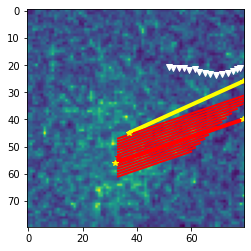

G:/.shortcut-targets-by-id/1agT5mnPWaZdQIB8nNNVWaVbqpbYNGxcB\2020-12-28\03-01-08_aka_02-01-08_L23_intralaminar ['Old', 'Diagram'] ['03-01-08_snr.txt', 'electrode.dat', 'corners_layer.dat', 'rois_01_to_12.dat', 'LaminarVisual03-01-08.png', 'rois_01_to_14.dat', 'desktop.ini']
slice 3 , rec 8
edge_pts [[55, 0], [73, 0]] axis_pts [[40, 47], [29, 36]]
laminar axis unit vectors: [0.5854905538443584, -0.8106792283998809] [0.5746304214759497, -0.8184130245263527]
Created roi: [[30, 35], [31, 34], [32, 33], [33, 32], [30, 36], [31, 35], [32, 34], [33, 33], [31, 37], [32, 36], [33, 35], [34, 34], [32, 37], [33, 36], [34, 35], [35, 34], [32, 38], [33, 37], [34, 36], [35, 35], [33, 39], [34, 38], [35, 37], [36, 36], [34, 39], [35, 38], [36, 37], [37, 36], [35, 40], [36, 39], [37, 38], [38, 37], [35, 41], [36, 40], [37, 39], [38, 38], [36, 42], [37, 41], [38, 40], [39, 39], [37, 42], [38, 41], [39, 40], [40, 39], [37, 43], [38, 42], [39, 41], [40, 40], [38, 44], [39, 43], [40, 42], [41, 41], [39, 4

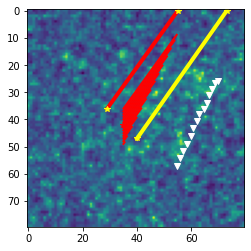

G:/.shortcut-targets-by-id/1agT5mnPWaZdQIB8nNNVWaVbqpbYNGxcB\2020-12-28\04-01-01_aka_03-01-01_L4_interlaminar ['Old', 'Diagram'] ['04-01-01_snr.txt', 'electrode.dat', 'corners_barrel.dat', 'rois_01_to_07.dat', 'LaminarVisual04-01-01.png', 'rois_01_to_09.dat', 'desktop.ini']
slice 4 , rec 1
edge_pts [[29, 79], [0, 79]] axis_pts [[26, 46], [44, 58]]
laminar axis unit vectors: [-0.5812381937190965, 0.813733471206735] [-0.6188722266035128, 0.7854916722275356]
Created roi: [[43, 59], [42, 60], [41, 61], [40, 62], [43, 58], [42, 59], [41, 60], [40, 61], [42, 58], [41, 59], [40, 60], [39, 61], [41, 57], [40, 58], [39, 59], [38, 60], [40, 57], [39, 58], [38, 59], [37, 60], [39, 56], [38, 57], [37, 58], [36, 59], [38, 55], [37, 56], [36, 57], [35, 58], [37, 54], [36, 55], [35, 56], [34, 57], [36, 54], [35, 55], [34, 56], [33, 57], [35, 53], [34, 54], [33, 55], [32, 56], [34, 53], [33, 54], [32, 55], [31, 56], [33, 52], [32, 53], [31, 54], [30, 55], [32, 51], [31, 52], [30, 53], [29, 54], [31, 5

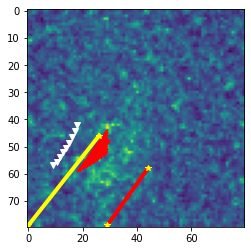

G:/.shortcut-targets-by-id/1agT5mnPWaZdQIB8nNNVWaVbqpbYNGxcB\2020-12-28\11-01-06_aka_part2_08-01-06_L4_interlaminar ['Old', 'Diagram'] ['11-01-06_snr.txt', 'electrode.dat', 'corners_barrel.dat', 'rois_01_to_16.dat', 'desktop.ini']
slice 11 , rec 6
edge_pts [[31, 0], [16, 0]] axis_pts [[19, 50], [34, 50]]
laminar axis unit vectors: [-0.05989229072794672, -0.9982048454657786] [-0.05989229072794672, -0.9982048454657786]
Created roi: [[34, 49], [33, 49], [32, 49], [31, 49], [30, 49], [29, 49], [28, 49], [27, 49], [26, 49], [25, 49], [24, 49], [23, 49], [22, 49], [21, 49], [20, 49], [19, 49], [18, 49], [17, 49], [16, 49], [15, 49], [14, 49], [13, 49], [12, 49], [11, 49], [10, 49], [9, 49], [8, 49], [7, 49], [6, 49], [5, 49], [4, 49], [3, 49], [2, 49], [1, 49], [0, 49]]
Created roi: [[34, 46], [33, 46], [32, 46], [31, 46], [30, 46], [29, 46], [28, 46], [27, 46], [26, 46], [25, 46], [24, 46], [23, 46], [22, 46], [21, 46], [20, 46], [19, 46], [18, 46], [17, 46], [16, 46], [15, 46], [14, 46], [

Created roi: [[22, 40], [23, 40], [24, 40], [25, 40], [26, 40], [27, 41], [28, 41], [29, 41], [30, 41], [31, 41], [32, 41], [33, 41], [34, 41], [35, 42], [36, 42], [37, 42], [38, 42], [39, 42], [40, 42], [41, 42], [42, 42], [43, 43], [44, 43], [45, 43], [46, 43], [47, 43], [48, 43], [49, 43], [50, 43], [51, 44], [52, 44], [53, 44], [54, 44], [55, 44], [56, 44], [57, 44], [58, 45], [59, 45], [60, 45], [61, 45], [62, 45], [63, 45], [64, 45], [65, 45], [66, 46], [67, 46], [68, 46], [69, 46], [70, 46], [71, 46], [72, 46], [73, 46], [74, 47], [75, 47], [76, 47], [77, 47], [78, 47], [79, 47], [79, 48], [79, 49], [79, 50], [79, 51], [79, 52], [79, 53], [79, 54], [79, 55], [79, 56], [79, 57], [79, 58], [79, 59], [79, 60], [79, 61], [79, 62], [79, 63], [79, 64], [79, 65], [79, 66], [79, 67], [79, 68], [79, 69], [79, 70], [79, 71], [79, 72], [79, 73], [79, 74], [79, 75], [79, 76], [79, 77], [79, 78], [79, 79]]
Created roi: [[21, 43], [22, 43], [23, 43], [24, 43], [25, 43], [26, 44], [27, 44], [2

slice 4 , rec 2
edge_pts [[2, 40], [69, 79]] axis_pts [[8, 22], [78, 62]]
laminar axis unit vectors: [-0.31622776601683794, 0.9486832980505138] [-0.46788772041903276, 0.8837879163470619]
Created roi: [[8, 23], [9, 23], [9, 24], [10, 24], [11, 25], [12, 25], [13, 26], [14, 26], [15, 27], [16, 28], [17, 28], [18, 29], [19, 29], [20, 30], [21, 30], [22, 31], [23, 32], [24, 32], [25, 33], [26, 33], [27, 34], [28, 34], [29, 35], [30, 36], [31, 36], [32, 37], [33, 37], [34, 38], [35, 38], [35, 39], [36, 39], [37, 40], [38, 40], [39, 41], [40, 41], [41, 42], [42, 42], [42, 43], [43, 43], [44, 44], [45, 44], [46, 45], [47, 45], [48, 46], [49, 47], [50, 47], [51, 48], [52, 48], [53, 49], [54, 49], [55, 50], [56, 51], [57, 51], [58, 52], [59, 52], [60, 53], [61, 53], [62, 54], [63, 55], [64, 55], [65, 56], [66, 56], [67, 57], [68, 57], [68, 58], [69, 58], [70, 59], [71, 59], [72, 60], [73, 60], [74, 61], [75, 61], [75, 62], [76, 62], [77, 63], [78, 63], [79, 64], [79, 65], [79, 66], [79, 67], [7

G:/.shortcut-targets-by-id/1agf9hjzkl3u6aOFBWL11nSv61hlCqOtg\2020-12-29\04-01-01_L4_interlaminar ['Old', 'Diagram'] ['04-01-01_snr.txt', 'electrode.dat', 'corners_barrel.dat', 'rois_01_to_16.dat', 'desktop.ini']
slice 4 , rec 1
edge_pts [[44, 0], [26, 0]] axis_pts [[26, 50], [44, 50]]
laminar axis unit vectors: [0.0, -1.0] [0.0, -1.0]
Created roi: [[44, 49], [43, 49], [42, 49], [41, 49], [40, 49], [39, 49], [38, 49], [37, 49], [36, 49], [35, 49], [34, 49], [33, 49], [32, 49], [31, 49], [30, 49], [29, 49], [28, 49], [27, 49], [26, 49], [25, 49], [24, 49], [23, 49], [22, 49], [21, 49], [20, 49], [19, 49], [18, 49], [17, 49], [16, 49], [15, 49], [14, 49], [13, 49], [12, 49], [11, 49], [10, 49], [9, 49], [8, 49], [7, 49], [6, 49], [5, 49], [4, 49], [3, 49], [2, 49], [1, 49], [0, 49]]
Created roi: [[44, 46], [43, 46], [42, 46], [41, 46], [40, 46], [39, 46], [38, 46], [37, 46], [36, 46], [35, 46], [34, 46], [33, 46], [32, 46], [31, 46], [30, 46], [29, 46], [28, 46], [27, 46], [26, 46], [25, 

Created file: G:/.shortcut-targets-by-id/1agf9hjzkl3u6aOFBWL11nSv61hlCqOtg\2020-12-29\06-01-01_L4_interlaminar/rois_01_to_17.dat
Stim point: [26, 53]
laminar_distances: [1.17, 4.17, 7.17, 10.17, 13.17, 16.17, 19.17, 22.17, 25.17, 28.17, 31.17, 34.17, 37.17, 40.17, 43.17, 46.17, 49.17]
laminar_distances: [1.0, 4.0, 7.0, 10.0, 13.0, 16.0, 19.0, 22.0, 25.0, 28.0, 31.0, 34.0, 37.0, 40.0, 43.0, 46.0, 49.0]
G:/.shortcut-targets-by-id/1agf9hjzkl3u6aOFBWL11nSv61hlCqOtg\2020-12-29\07-01-03_L4_intralaminar ['Diagram'] ['07-01-03_snr.txt', 'electrode.dat', 'corners_layer.dat', 'rois_01_to_16.dat', 'desktop.ini']
slice 7 , rec 3
edge_pts [[78, 29], [78, 0]] axis_pts [[32, 46], [47, 63]]
laminar axis unit vectors: [0.6737538576856826, -0.7389558439133294] [0.7071067811865476, -0.7071067811865476]
Created roi: [[48, 62], [49, 61], [50, 60], [51, 59], [47, 62], [48, 61], [49, 60], [50, 59], [46, 61], [47, 60], [48, 59], [49, 58], [46, 60], [47, 59], [48, 58], [49, 57], [45, 59], [46, 58], [47, 57], [

Created roi: [[64, 45], [65, 44], [66, 43], [67, 42], [63, 44], [64, 43], [65, 42], [66, 41], [63, 43], [64, 42], [65, 41], [66, 40], [62, 42], [63, 41], [64, 40], [65, 39], [61, 42], [62, 41], [63, 40], [64, 39], [61, 41], [62, 40], [63, 39], [64, 38], [60, 40], [61, 39], [62, 38], [63, 37], [59, 39], [60, 38], [61, 37], [62, 36], [58, 38], [59, 37], [60, 36], [61, 35], [57, 37], [58, 36], [59, 35], [60, 34], [57, 36], [58, 35], [59, 34], [60, 33], [56, 36], [57, 35], [58, 34], [59, 33], [55, 35], [56, 34], [57, 33], [58, 32], [55, 34], [56, 33], [57, 32], [58, 31], [54, 33], [55, 32], [56, 31], [57, 30], [53, 33], [54, 32], [55, 31], [56, 30], [53, 32], [54, 31], [55, 30], [56, 29], [52, 31], [53, 30], [54, 29], [55, 28], [51, 30], [52, 29], [53, 28], [54, 27], [50, 29], [51, 28], [52, 27], [53, 26], [49, 28], [50, 27], [51, 26], [52, 25], [49, 27], [50, 26], [51, 25], [52, 24], [48, 27], [49, 26], [50, 25], [51, 24], [47, 26], [48, 25], [49, 24], [50, 23], [47, 25], [48, 24], [49, 2

edge_pts [[28, 79], [79, 66]] axis_pts [[34, 58], [79, 43]]
laminar axis unit vectors: [-0.27472112789737807, 0.9615239476408232] [0.0, 1.0]
Created roi: [[34, 59], [35, 59], [36, 58], [37, 58], [38, 58], [38, 57], [39, 57], [40, 57], [41, 56], [42, 56], [43, 56], [44, 55], [45, 55], [46, 55], [47, 55], [48, 54], [49, 54], [50, 54], [51, 53], [52, 53], [53, 53], [54, 52], [55, 52], [56, 52], [56, 51], [57, 51], [58, 51], [59, 50], [60, 50], [61, 50], [62, 49], [63, 49], [64, 49], [65, 49], [66, 48], [67, 48], [68, 48], [69, 47], [70, 47], [71, 47], [72, 46], [73, 46], [74, 46], [75, 45], [76, 45], [77, 44], [78, 44], [79, 44], [79, 43], [79, 42], [79, 41], [79, 40], [79, 39], [79, 38], [79, 37], [79, 36], [79, 35], [79, 34], [79, 33], [79, 32], [79, 31], [79, 30], [79, 29], [79, 28], [79, 27], [79, 26], [79, 25], [79, 24], [79, 23], [79, 22], [79, 21], [79, 20], [79, 19], [79, 18], [79, 17], [79, 16], [79, 15], [79, 14], [79, 13], [79, 12], [79, 11], [79, 10], [79, 9], [79, 8], [79, 7]

Created roi: [[24, 36], [25, 36], [26, 36], [27, 36], [28, 36], [29, 36], [30, 36], [31, 36], [32, 36], [33, 36], [34, 36], [35, 36], [36, 37], [37, 37], [38, 37], [39, 37], [40, 37], [41, 37], [42, 37], [43, 37], [44, 37], [45, 37], [46, 37], [47, 37], [48, 37], [49, 37], [50, 37], [51, 37], [52, 37], [53, 37], [54, 37], [55, 37], [56, 37], [57, 37], [58, 37], [59, 38], [60, 38], [61, 38], [62, 38], [63, 38], [64, 38], [65, 38], [66, 38], [67, 38], [68, 38], [69, 38], [70, 38], [71, 38], [72, 38], [73, 38], [74, 38], [75, 38], [76, 38], [77, 38], [78, 38], [79, 38], [79, 39], [79, 40], [79, 41], [79, 42], [79, 43], [79, 44], [79, 45], [79, 46], [79, 47], [79, 48], [79, 49], [79, 50], [79, 51], [79, 52], [79, 53], [79, 54], [79, 55], [79, 56], [79, 57], [79, 58], [79, 59]]
Created roi: [[24, 39], [25, 39], [26, 39], [27, 39], [28, 39], [29, 39], [30, 39], [31, 39], [32, 39], [33, 39], [34, 39], [35, 39], [36, 40], [37, 40], [38, 40], [39, 40], [40, 40], [41, 40], [42, 40], [43, 40], [4

slice 9 , rec 1
edge_pts [[48, 79], [29, 79]] axis_pts [[27, 34], [44, 34]]
laminar axis unit vectors: [0.08853979028379436, 0.9960726406926864] [0.04440061362072038, 0.9990138064662086]
Created roi: [[44, 35], [43, 35], [42, 35], [41, 35], [40, 35], [39, 35], [38, 35], [37, 35], [36, 35], [35, 35], [34, 35], [33, 35], [32, 35], [31, 35], [30, 35], [29, 35], [28, 35], [27, 35], [26, 35], [25, 35], [24, 35], [23, 35], [22, 35], [21, 35], [20, 35], [19, 35], [18, 35], [17, 35], [16, 35], [15, 35], [14, 35], [13, 35], [12, 35], [11, 35], [10, 35], [9, 35], [8, 35], [7, 35], [6, 35], [5, 35], [4, 35], [3, 35], [2, 35], [1, 35], [0, 35]]
Created roi: [[44, 38], [43, 38], [42, 38], [41, 38], [40, 38], [39, 38], [38, 38], [37, 38], [36, 38], [35, 38], [34, 38], [33, 38], [32, 38], [31, 38], [30, 38], [29, 38], [28, 38], [27, 38], [26, 38], [25, 38], [24, 38], [23, 38], [22, 38], [21, 38], [20, 38], [19, 38], [18, 38], [17, 38], [16, 38], [15, 38], [14, 38], [13, 38], [12, 38], [11, 38], [10, 

Created roi: [[33, 77], [34, 76], [34, 75], [34, 74], [35, 74], [35, 73], [36, 72], [36, 71], [37, 70], [37, 69], [38, 68], [38, 67], [39, 66], [39, 65], [40, 64], [40, 63], [41, 62], [41, 61], [42, 60], [42, 59], [43, 58], [44, 57], [44, 56], [45, 55], [45, 54], [45, 53], [46, 52], [46, 51], [47, 50], [48, 49], [48, 48], [49, 47], [49, 46], [50, 45], [50, 44], [50, 43], [51, 42], [52, 41], [52, 40], [53, 39], [53, 38], [54, 37], [54, 36], [55, 35], [55, 34], [56, 34], [56, 33], [56, 32], [57, 31], [57, 30], [58, 29], [58, 28], [59, 27], [59, 26], [60, 26], [60, 25], [61, 24], [61, 23], [61, 22], [62, 21], [62, 20], [63, 19], [63, 18], [64, 18], [64, 17], [65, 16], [65, 15], [66, 14], [66, 13], [67, 12], [67, 11], [67, 10], [68, 10], [68, 9], [69, 8], [69, 7], [70, 6], [70, 5], [71, 4], [71, 3], [72, 2], [72, 1], [73, 0], [74, 0], [75, 0], [76, 0], [77, 0], [78, 0], [79, 0]]
Created roi: [[36, 78], [37, 77], [37, 76], [38, 75], [38, 74], [39, 73], [39, 72], [39, 71], [40, 70], [41, 69]

<Figure size 432x288 with 0 Axes>

In [2]:
data_dir = "C:/Users/jjudge3/Desktop/Data/Kate's/ROI_dist/"
data_dir = "G:/.shortcut-targets-by-id/"
corners_file_prefix_layer = 'corners_layer'
corners_file_prefix_barrel = 'corners_barrel'
electrode_file_prefix = 'electrode'
rois_file_prefix = 'rois' # e.g. 'rois_01_to_09.dat'
snr_file_prefix = 'SNR'

image_data = {}
n_plots = 5  # how many to show

for subdir, dirs, files in os.walk(data_dir):
    depth = subdir.count('/') + subdir.count('\\')
    if depth > 4:  # don't care about any deeper dir
        continue
    if 'notUsable' in subdir:
        continue
    if depth == 4:
        print(subdir, dirs, files)
    subdir += '/'
    for filename in files:
        if filename.split(".")[0].endswith("_snr"):
            name_parse = filename[:8]  # of the format 07_01_01
            try:
                slic, loc, rec = [int(x) for x in name_parse.split('-')]
            except ValueError:
                continue
            if slic not in image_data:
                image_data[slic] = {}
            if loc not in image_data[slic]:
                image_data[slic][loc] = {}
            snr = np.loadtxt(subdir + filename,
                             delimiter='\t',
                             usecols=(1,))
            width = int(np.sqrt(snr.shape[0]))
            snr = snr.reshape((width, width))

            print("slice", slic, ", rec", rec)

            # open corners, interlaminar, 2 points p1, p2 to define the edge along which to measure
            
            for la_file in [subdir + corners_file_prefix_layer + '.dat', 
                            subdir + corners_file_prefix_barrel + '.dat']:
                lines = None
                if os.path.exists(la_file):
                    with open(la_file, 'r') as f:
                        lines = f.readlines() 
                    corners = [int(x) for x in lines[4:]] # the last 4 lines are diode numbers of corners
                    layer_axes = LayerAxes(corners)
                    laminar_axis, laminar_axis_2 = layer_axes.get_layer_axes()
                    print("laminar axis unit vectors:", laminar_axis.get_unit_vector(), 
                          laminar_axis_2.get_unit_vector())

                    # make our own ROIs from the list of edges and write them to a .dat file
                    roi_cr = ROICreator(layer_axes)
                    rois = roi_cr.get_rois()  # list of list of points
                    #   rois = ROIFileReader(rois_file).get_roi_list()
                    roi_centers = [r.get_center() for r in rois]
                    roi_centers = [[round(r[0], 2), round(r[1], 2)] for r in roi_centers]
                    print("ROI centers:", roi_centers)
                    
                    # write these ROIs to file
                    roi_cr.write_roi_file(subdir, rois_file_prefix)

                    # open stim point roi as a single integer (its diode number) in variable stim_pt
                    sp_file = subdir + electrode_file_prefix + '.dat'
                    with open(sp_file, 'r') as f:
                        lines = f.readlines()
                    stim_pt = int(lines[-1]) # last line is always electrode location
                    aux_obj = LaminarROI([stim_pt]).get_points()
                    stim_pt = aux_obj[0]  # should be a list of len 2, representing px location [x, y]
                    print("Stim point:", stim_pt)

                    # run laminar dist computation
                    laminar_distances = LaminarDistance(laminar_axis, rois, stim_pt).compute_laminar_distances()
                    laminar_distances = [round(ld, 2) for ld in laminar_distances]
                    print('laminar_distances:', laminar_distances)  # a list of integers with same indexing as rois

                    # run laminar dist again with the other axis
                    laminar_distances_2 = LaminarDistance(laminar_axis_2, rois, stim_pt).compute_laminar_distances()
                    laminar_distances_2 = [round(ld, 2) for ld in laminar_distances_2]
                    print('laminar_distances:', laminar_distances_2)  # a list of integers with same indexing as rois

                    image_data[slic][loc][rec] = {
                        'snr': snr,
                        'filename': filename,
                        'laminar_distances': laminar_distances}

                    # Now that the data is stored, show intermediate computations in plot
                    if n_plots > 0:
                        lines = [laminar_axis.get_line_repr(),
                                 laminar_axis_2.get_line_repr()]
                        line_colors = ['red', 'yellow']
                        linewidths = [4,4]
                        other_colors = ['red']

                        # laminar aux lines
                        uv = laminar_axis.get_unit_vector()
                        for i in range(len(laminar_distances)):
                            ld = laminar_distances[i]
                            jiggle = i - int(len(laminar_distances) / 2)
                            stim_proxy_pt = [stim_pt[0], stim_pt[1] - jiggle]
                            measure_vector = [uv[0] * ld + stim_proxy_pt[0], uv[1] * ld + stim_proxy_pt[1]]
                            lines.append([measure_vector, stim_proxy_pt])
                            line_colors.append(other_colors[i % len(other_colors)])
                            linewidths.append(2)

                        LaminarVisualization(snr, 
                                             stim_pt, 
                                             roi_centers, 
                                             layer_axes.get_corners(),
                                             lines,
                                             line_colors,
                                             linewidths,
                                             save_dir=subdir+"LaminarVisual"+name_parse+'.png')
                        n_plots -= 1
